In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb 
# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [2]:
types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv("./assets/train_v2.csv", parse_dates=[2], nrows=66901, dtype=types)
store = pd.read_csv("./assets/store.csv")

In [3]:
not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))

No closed store with sales: True


In [4]:
no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))

No open store with no sales: True


In [5]:
train = train.loc[train['Sales'] > 0]
assert(train[train['Sales'] == 0].size == 0)

In [6]:
dates = pd.to_datetime(train['Date'], format="%Y%m%d:%H:%M:%S.%f").sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values
assert(all(dates == date_range))

Start date:  2014-11-26T00:00:00.000000000
End Date:  2015-01-30T00:00:00.000000000


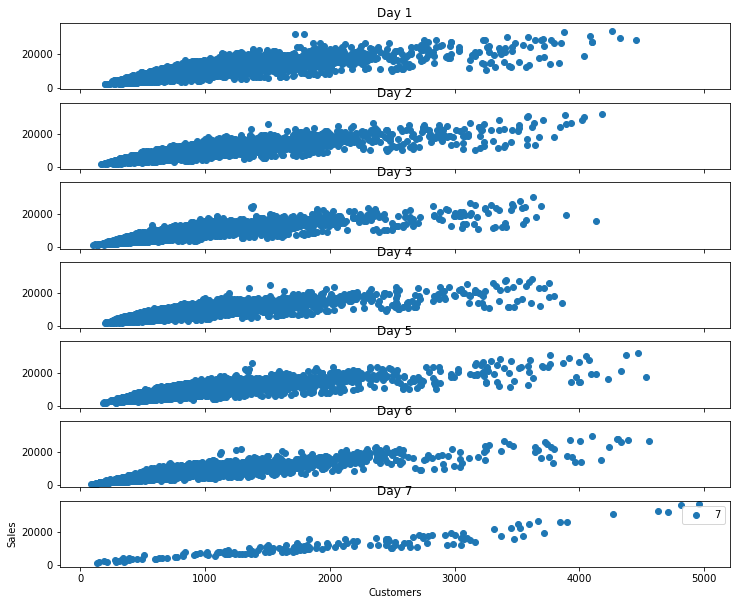

In [7]:
f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    mask = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

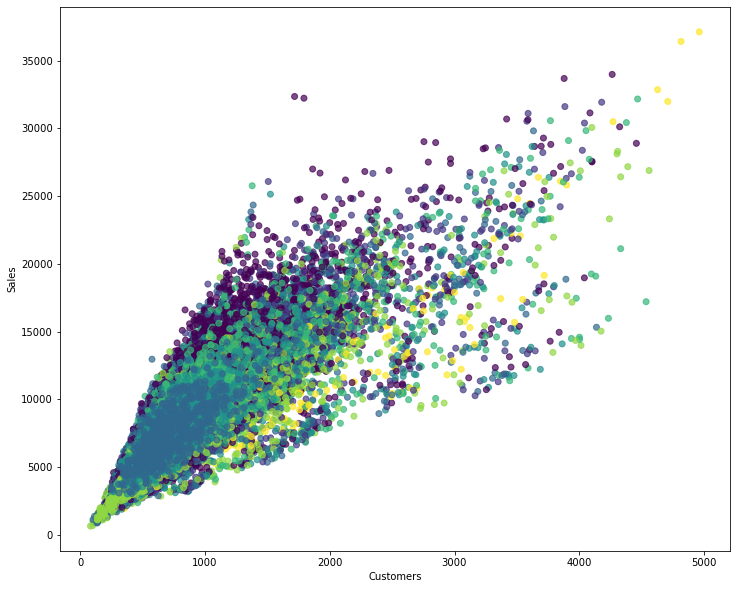

In [8]:
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

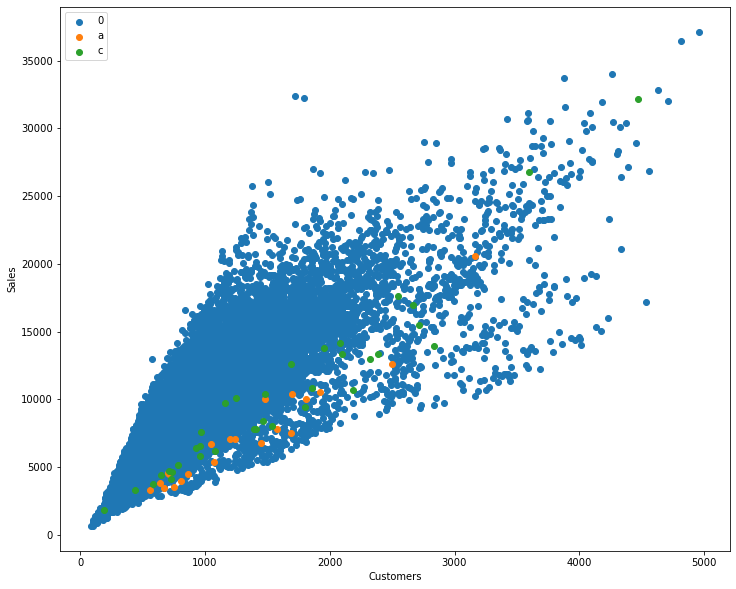

In [9]:
for i in ["0", "a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

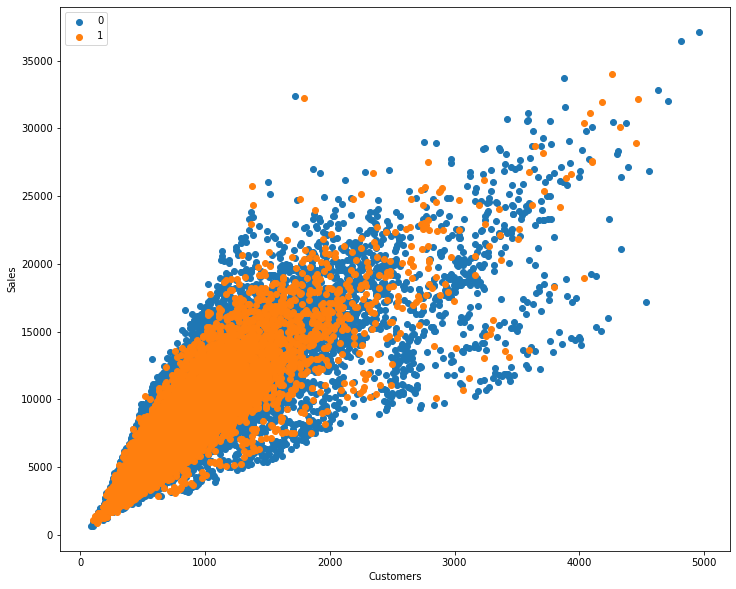

In [10]:
for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

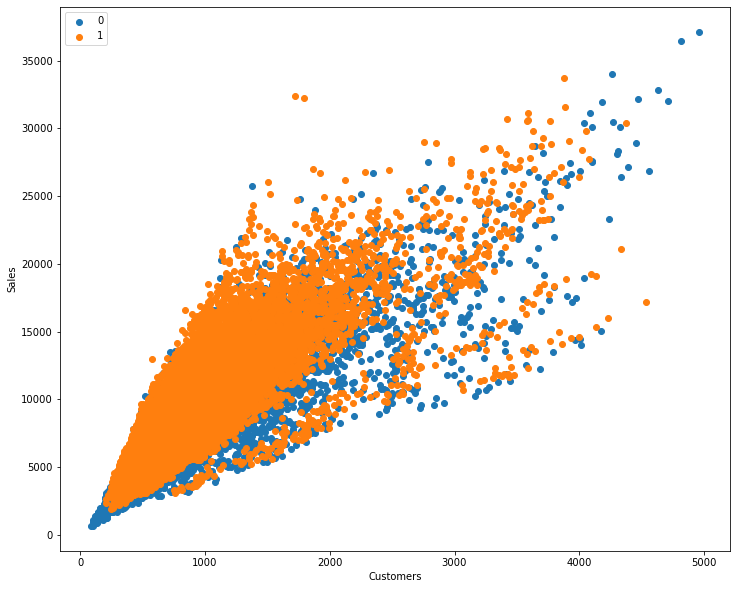

In [11]:
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [12]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

avg_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store = pd.merge(avg_store.reset_index(), store, on='Store')
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5574.037037,644.407407,8.574182,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5593.407407,602.833333,9.132443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,7560.740741,797.296296,9.363221,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,10730.296296,1424.888889,7.481731,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5313.981481,564.833333,9.273212,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


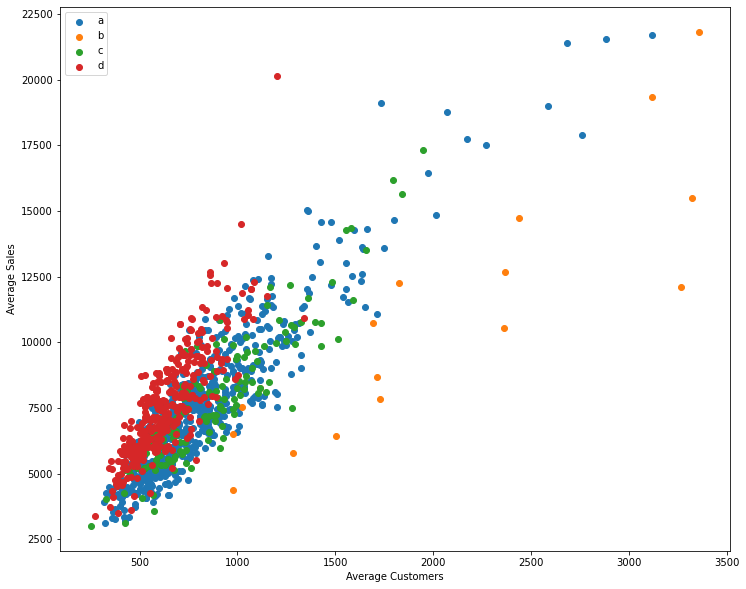

In [13]:
for i in ['a', 'b', 'c', 'd']:
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

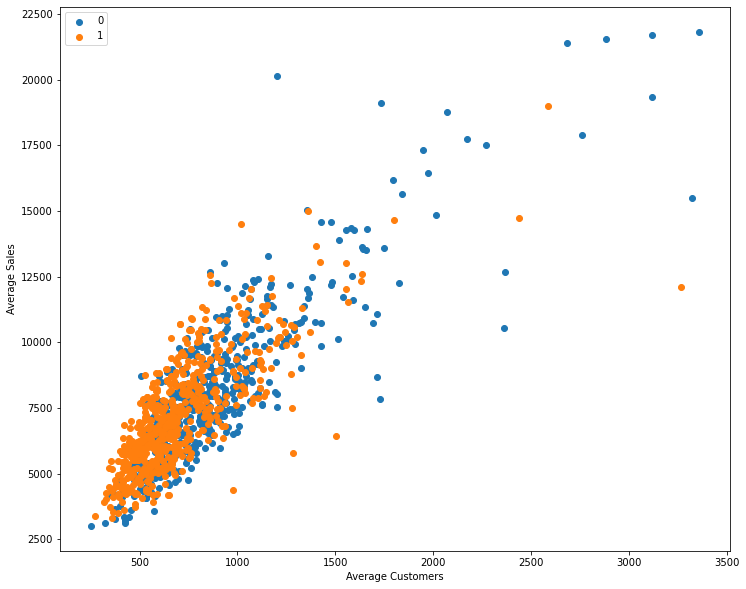

In [14]:
for i in [0, 1]:
    data = store[store['Promo2'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

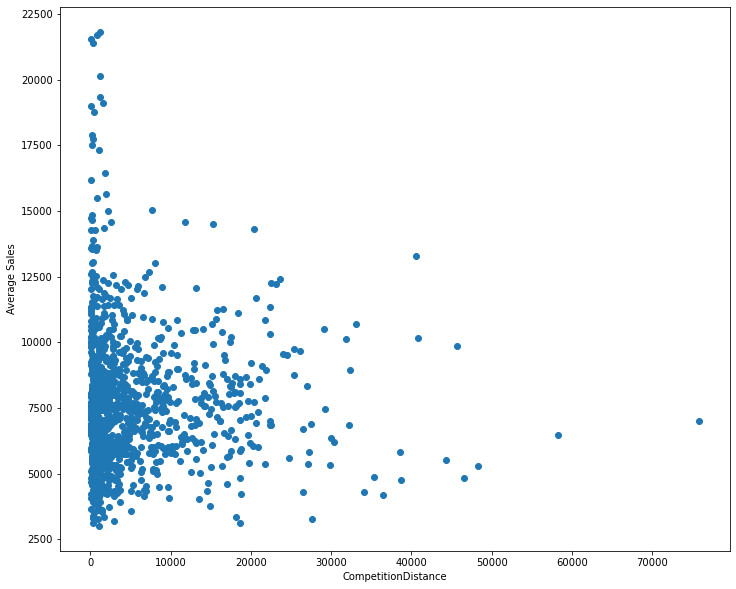

In [15]:
# fill NaN values
store["CompetitionDistance"].fillna(-1)
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()

In [16]:
def build_features(train, store):
    # Convert string types into integers
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes

    merged = pd.merge(train, store, on='Store', how='left')
    
    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    
    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    merged['Week'] = merged.Date.dt.week
    
    # Number of months that competition has existed for
    merged['MonthsCompetitionOpen'] = \
        12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + \
        (merged['Month'] - merged['CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear'] ==
               NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace
    
    # Number of weeks that promotion has existed for
    merged['WeeksPromoOpen'] = \
        12 * (merged['Year'] - merged['Promo2SinceYear']) + \
        (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear'] == 
               NaN_replace, 'WeeksPromoOpen'] = NaN_replace

    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 
        'Promo2SinceYear', 
        'MonthsCompetitionOpen', 
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)

    return merged

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()

C:\Users\hp\AppData\Local\Temp/ipykernel_9784/760113941.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = merged.Date.dt.week
C:\Users\hp\AppData\Local\Temp/ipykernel_9784/760113941.py:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-01-30,5577,616,1,1,0,0,9.053571,...,0,0,0,0,2015,1,30,5,76,0
1,2,5,2015-01-30,5919,624,1,1,0,0,9.485577,...,1,13,2010,"Jan,Apr,Jul,Oct",2015,1,30,5,86,52
2,3,5,2015-01-30,6911,678,1,1,0,0,10.193215,...,1,14,2011,"Jan,Apr,Jul,Oct",2015,1,30,5,97,39
3,4,5,2015-01-30,13307,1632,1,1,0,0,8.153799,...,0,0,0,0,2015,1,30,5,64,0
4,5,5,2015-01-30,5640,617,1,1,0,0,9.141005,...,0,0,0,0,2015,1,30,5,-3,0


In [17]:
from sklearn.model_selection import train_test_split
X = [
    'Store', 
    'Customers',
    'CompetitionDistance', 

    'Promo', 
    'Promo2', 

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',
    
    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Error calculating function according to kaggle
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_hat))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)

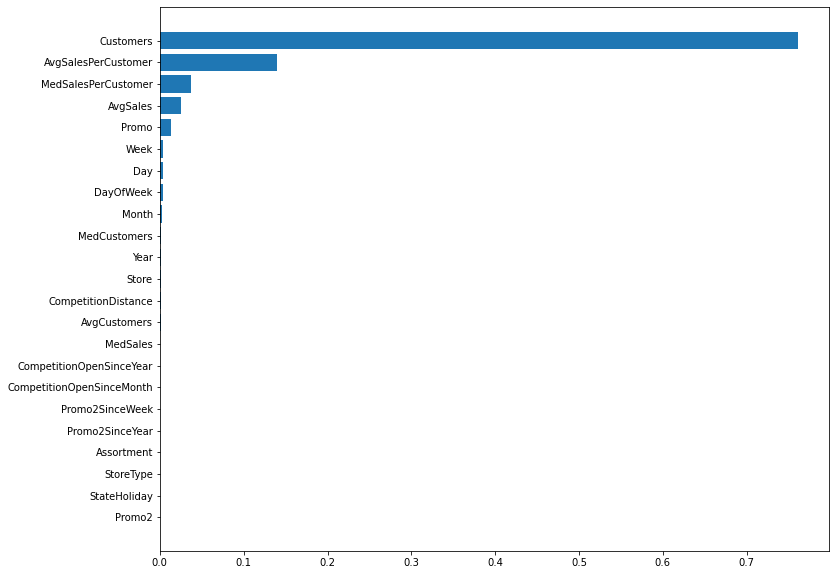

In [19]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
plot_importance(decision_tree)

In [20]:
y_hat = decision_tree.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)

Mean -0.0851866022179377
Variance 6.386275109412945e-07
RMSPE 0.08257641778108815


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.3s finished


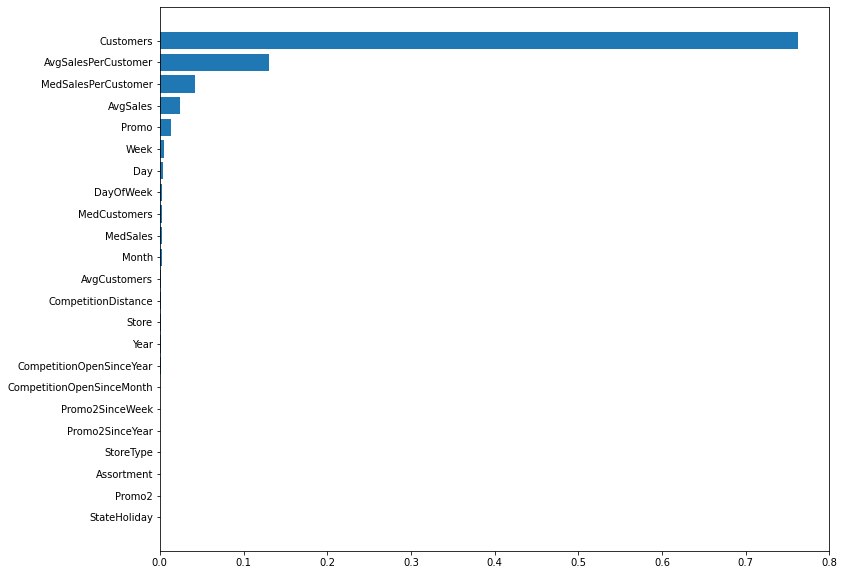

In [21]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
plot_importance(randomForest)

In [22]:
y_hat = randomForest.predict(X_test)
score(randomForest, X_train, y_train, y_test, y_hat)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  2

Mean -0.06089112129591201
Variance 5.744540652405267e-07
RMSPE 0.05967590262275576


[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished


In [23]:
import xgboost as xgb

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[X], np.log1p(y_train), 
                 eval_set = [(X_train[X], np.log1p(y_train)), (X_test[X], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )

[11:50:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:7.53662	validation_0-rmspe:0.99957	validation_1-rmse:7.53602	validation_1-rmspe:0.99957
[1]	validation_0-rmse:6.78395	validation_0-rmspe:0.99892	validation_1-rmse:6.78346	validation_1-rmspe:0.99892
[2]	validation_0-rmse:6.10655	validation_0-rmspe:0.99774	validation_1-rmse:6.10602	validation_1-rmspe:0.99775
[3]	validation_0-rmse:5.49703	validation_0-rmspe:0.99575	validation_1-rmse:5.49642	validation_1-rmspe:0.99576
[4]	validation_0-rmse:4.94849	validation_0-rmspe:0.99258	validation_1-rmse:4.94778	validation_1-rmspe:0.99259
[5]	validation_0-rmse:4.45482	validation_0-rmspe:0.98781	validation_1-rmse:4.45400	validation

[71]	validation_0-rmse:0.08703	validation_0-rmspe:0.08783	validation_1-rmse:0.08645	validation_1-rmspe:0.08652
[72]	validation_0-rmse:0.08631	validation_0-rmspe:0.08718	validation_1-rmse:0.08572	validation_1-rmspe:0.08583
[73]	validation_0-rmse:0.08568	validation_0-rmspe:0.08647	validation_1-rmse:0.08514	validation_1-rmspe:0.08525
[74]	validation_0-rmse:0.08509	validation_0-rmspe:0.08579	validation_1-rmse:0.08463	validation_1-rmspe:0.08470
[75]	validation_0-rmse:0.08448	validation_0-rmspe:0.08527	validation_1-rmse:0.08403	validation_1-rmspe:0.08419
[76]	validation_0-rmse:0.08384	validation_0-rmspe:0.08465	validation_1-rmse:0.08332	validation_1-rmspe:0.08350
[77]	validation_0-rmse:0.08338	validation_0-rmspe:0.08398	validation_1-rmse:0.08291	validation_1-rmspe:0.08297
[78]	validation_0-rmse:0.08278	validation_0-rmspe:0.08341	validation_1-rmse:0.08231	validation_1-rmspe:0.08239
[79]	validation_0-rmse:0.08224	validation_0-rmspe:0.08289	validation_1-rmse:0.08172	validation_1-rmspe:0.08181
[

[145]	validation_0-rmse:0.06674	validation_0-rmspe:0.06693	validation_1-rmse:0.06649	validation_1-rmspe:0.06644
[146]	validation_0-rmse:0.06657	validation_0-rmspe:0.06676	validation_1-rmse:0.06634	validation_1-rmspe:0.06629
[147]	validation_0-rmse:0.06643	validation_0-rmspe:0.06661	validation_1-rmse:0.06621	validation_1-rmspe:0.06616
[148]	validation_0-rmse:0.06632	validation_0-rmspe:0.06652	validation_1-rmse:0.06611	validation_1-rmspe:0.06607
[149]	validation_0-rmse:0.06616	validation_0-rmspe:0.06637	validation_1-rmse:0.06594	validation_1-rmspe:0.06591
[150]	validation_0-rmse:0.06608	validation_0-rmspe:0.06629	validation_1-rmse:0.06584	validation_1-rmspe:0.06580
[151]	validation_0-rmse:0.06593	validation_0-rmspe:0.06614	validation_1-rmse:0.06568	validation_1-rmspe:0.06565
[152]	validation_0-rmse:0.06580	validation_0-rmspe:0.06601	validation_1-rmse:0.06556	validation_1-rmspe:0.06552
[153]	validation_0-rmse:0.06569	validation_0-rmspe:0.06591	validation_1-rmse:0.06544	validation_1-rmspe:

[219]	validation_0-rmse:0.06116	validation_0-rmspe:0.06125	validation_1-rmse:0.06102	validation_1-rmspe:0.06091
[220]	validation_0-rmse:0.06111	validation_0-rmspe:0.06120	validation_1-rmse:0.06098	validation_1-rmspe:0.06086
[221]	validation_0-rmse:0.06106	validation_0-rmspe:0.06114	validation_1-rmse:0.06091	validation_1-rmspe:0.06080
[222]	validation_0-rmse:0.06103	validation_0-rmspe:0.06112	validation_1-rmse:0.06089	validation_1-rmspe:0.06077
[223]	validation_0-rmse:0.06100	validation_0-rmspe:0.06109	validation_1-rmse:0.06086	validation_1-rmspe:0.06074
[224]	validation_0-rmse:0.06096	validation_0-rmspe:0.06104	validation_1-rmse:0.06081	validation_1-rmspe:0.06069
[225]	validation_0-rmse:0.06093	validation_0-rmspe:0.06102	validation_1-rmse:0.06078	validation_1-rmspe:0.06067
[226]	validation_0-rmse:0.06087	validation_0-rmspe:0.06095	validation_1-rmse:0.06073	validation_1-rmspe:0.06060
[227]	validation_0-rmse:0.06082	validation_0-rmspe:0.06090	validation_1-rmse:0.06068	validation_1-rmspe:

[293]	validation_0-rmse:0.05878	validation_0-rmspe:0.05881	validation_1-rmse:0.05871	validation_1-rmspe:0.05857
[294]	validation_0-rmse:0.05876	validation_0-rmspe:0.05879	validation_1-rmse:0.05870	validation_1-rmspe:0.05856
[295]	validation_0-rmse:0.05874	validation_0-rmspe:0.05877	validation_1-rmse:0.05868	validation_1-rmspe:0.05854
[296]	validation_0-rmse:0.05870	validation_0-rmspe:0.05874	validation_1-rmse:0.05864	validation_1-rmspe:0.05850
[297]	validation_0-rmse:0.05868	validation_0-rmspe:0.05871	validation_1-rmse:0.05862	validation_1-rmspe:0.05848
[298]	validation_0-rmse:0.05867	validation_0-rmspe:0.05869	validation_1-rmse:0.05860	validation_1-rmspe:0.05846
[299]	validation_0-rmse:0.05864	validation_0-rmspe:0.05867	validation_1-rmse:0.05859	validation_1-rmspe:0.05844
[300]	validation_0-rmse:0.05862	validation_0-rmspe:0.05865	validation_1-rmse:0.05858	validation_1-rmspe:0.05843
[301]	validation_0-rmse:0.05859	validation_0-rmspe:0.05862	validation_1-rmse:0.05855	validation_1-rmspe:

[367]	validation_0-rmse:0.05746	validation_0-rmspe:0.05747	validation_1-rmse:0.05748	validation_1-rmspe:0.05734
[368]	validation_0-rmse:0.05745	validation_0-rmspe:0.05745	validation_1-rmse:0.05746	validation_1-rmspe:0.05732
[369]	validation_0-rmse:0.05743	validation_0-rmspe:0.05743	validation_1-rmse:0.05745	validation_1-rmspe:0.05731
[370]	validation_0-rmse:0.05743	validation_0-rmspe:0.05743	validation_1-rmse:0.05745	validation_1-rmspe:0.05731
[371]	validation_0-rmse:0.05741	validation_0-rmspe:0.05741	validation_1-rmse:0.05744	validation_1-rmspe:0.05730
[372]	validation_0-rmse:0.05741	validation_0-rmspe:0.05741	validation_1-rmse:0.05743	validation_1-rmspe:0.05729
[373]	validation_0-rmse:0.05740	validation_0-rmspe:0.05740	validation_1-rmse:0.05742	validation_1-rmspe:0.05728
[374]	validation_0-rmse:0.05737	validation_0-rmspe:0.05737	validation_1-rmse:0.05739	validation_1-rmspe:0.05725
[375]	validation_0-rmse:0.05736	validation_0-rmspe:0.05736	validation_1-rmse:0.05738	validation_1-rmspe:

[441]	validation_0-rmse:0.05661	validation_0-rmspe:0.05662	validation_1-rmse:0.05671	validation_1-rmspe:0.05658
[442]	validation_0-rmse:0.05661	validation_0-rmspe:0.05661	validation_1-rmse:0.05671	validation_1-rmspe:0.05657
[443]	validation_0-rmse:0.05660	validation_0-rmspe:0.05660	validation_1-rmse:0.05670	validation_1-rmspe:0.05657
[444]	validation_0-rmse:0.05659	validation_0-rmspe:0.05659	validation_1-rmse:0.05670	validation_1-rmspe:0.05656
[445]	validation_0-rmse:0.05658	validation_0-rmspe:0.05659	validation_1-rmse:0.05669	validation_1-rmspe:0.05656
[446]	validation_0-rmse:0.05658	validation_0-rmspe:0.05658	validation_1-rmse:0.05668	validation_1-rmspe:0.05654
[447]	validation_0-rmse:0.05656	validation_0-rmspe:0.05656	validation_1-rmse:0.05667	validation_1-rmspe:0.05653
[448]	validation_0-rmse:0.05656	validation_0-rmspe:0.05656	validation_1-rmse:0.05667	validation_1-rmspe:0.05653
[449]	validation_0-rmse:0.05655	validation_0-rmspe:0.05656	validation_1-rmse:0.05666	validation_1-rmspe:

[515]	validation_0-rmse:0.05609	validation_0-rmspe:0.05608	validation_1-rmse:0.05626	validation_1-rmspe:0.05613
[516]	validation_0-rmse:0.05608	validation_0-rmspe:0.05607	validation_1-rmse:0.05625	validation_1-rmspe:0.05612
[517]	validation_0-rmse:0.05607	validation_0-rmspe:0.05606	validation_1-rmse:0.05625	validation_1-rmspe:0.05612
[518]	validation_0-rmse:0.05607	validation_0-rmspe:0.05606	validation_1-rmse:0.05625	validation_1-rmspe:0.05612
[519]	validation_0-rmse:0.05606	validation_0-rmspe:0.05605	validation_1-rmse:0.05625	validation_1-rmspe:0.05611
[520]	validation_0-rmse:0.05606	validation_0-rmspe:0.05604	validation_1-rmse:0.05624	validation_1-rmspe:0.05611
[521]	validation_0-rmse:0.05605	validation_0-rmspe:0.05604	validation_1-rmse:0.05624	validation_1-rmspe:0.05611
[522]	validation_0-rmse:0.05604	validation_0-rmspe:0.05602	validation_1-rmse:0.05622	validation_1-rmspe:0.05609
[523]	validation_0-rmse:0.05603	validation_0-rmspe:0.05601	validation_1-rmse:0.05622	validation_1-rmspe:

[589]	validation_0-rmse:0.05559	validation_0-rmspe:0.05557	validation_1-rmse:0.05582	validation_1-rmspe:0.05569
[590]	validation_0-rmse:0.05558	validation_0-rmspe:0.05556	validation_1-rmse:0.05582	validation_1-rmspe:0.05568
[591]	validation_0-rmse:0.05558	validation_0-rmspe:0.05556	validation_1-rmse:0.05581	validation_1-rmspe:0.05567
[592]	validation_0-rmse:0.05557	validation_0-rmspe:0.05555	validation_1-rmse:0.05580	validation_1-rmspe:0.05567
[593]	validation_0-rmse:0.05556	validation_0-rmspe:0.05554	validation_1-rmse:0.05579	validation_1-rmspe:0.05566
[594]	validation_0-rmse:0.05556	validation_0-rmspe:0.05554	validation_1-rmse:0.05579	validation_1-rmspe:0.05565
[595]	validation_0-rmse:0.05556	validation_0-rmspe:0.05554	validation_1-rmse:0.05579	validation_1-rmspe:0.05565
[596]	validation_0-rmse:0.05555	validation_0-rmspe:0.05553	validation_1-rmse:0.05578	validation_1-rmspe:0.05565
[597]	validation_0-rmse:0.05555	validation_0-rmspe:0.05553	validation_1-rmse:0.05578	validation_1-rmspe:

[663]	validation_0-rmse:0.05520	validation_0-rmspe:0.05519	validation_1-rmse:0.05546	validation_1-rmspe:0.05533
[664]	validation_0-rmse:0.05520	validation_0-rmspe:0.05518	validation_1-rmse:0.05545	validation_1-rmspe:0.05533
[665]	validation_0-rmse:0.05520	validation_0-rmspe:0.05518	validation_1-rmse:0.05545	validation_1-rmspe:0.05532
[666]	validation_0-rmse:0.05519	validation_0-rmspe:0.05517	validation_1-rmse:0.05545	validation_1-rmspe:0.05532
[667]	validation_0-rmse:0.05519	validation_0-rmspe:0.05517	validation_1-rmse:0.05545	validation_1-rmspe:0.05532
[668]	validation_0-rmse:0.05519	validation_0-rmspe:0.05517	validation_1-rmse:0.05545	validation_1-rmspe:0.05532
[669]	validation_0-rmse:0.05518	validation_0-rmspe:0.05516	validation_1-rmse:0.05544	validation_1-rmspe:0.05532
[670]	validation_0-rmse:0.05517	validation_0-rmspe:0.05516	validation_1-rmse:0.05544	validation_1-rmspe:0.05532
[671]	validation_0-rmse:0.05517	validation_0-rmspe:0.05515	validation_1-rmse:0.05544	validation_1-rmspe:

[737]	validation_0-rmse:0.05491	validation_0-rmspe:0.05489	validation_1-rmse:0.05523	validation_1-rmspe:0.05509
[738]	validation_0-rmse:0.05491	validation_0-rmspe:0.05489	validation_1-rmse:0.05522	validation_1-rmspe:0.05508
[739]	validation_0-rmse:0.05491	validation_0-rmspe:0.05488	validation_1-rmse:0.05522	validation_1-rmspe:0.05508
[740]	validation_0-rmse:0.05491	validation_0-rmspe:0.05488	validation_1-rmse:0.05522	validation_1-rmspe:0.05508
[741]	validation_0-rmse:0.05491	validation_0-rmspe:0.05488	validation_1-rmse:0.05522	validation_1-rmspe:0.05508
[742]	validation_0-rmse:0.05490	validation_0-rmspe:0.05488	validation_1-rmse:0.05521	validation_1-rmspe:0.05508
[743]	validation_0-rmse:0.05490	validation_0-rmspe:0.05488	validation_1-rmse:0.05521	validation_1-rmspe:0.05507
[744]	validation_0-rmse:0.05490	validation_0-rmspe:0.05487	validation_1-rmse:0.05520	validation_1-rmspe:0.05507
[745]	validation_0-rmse:0.05489	validation_0-rmspe:0.05487	validation_1-rmse:0.05520	validation_1-rmspe:

[811]	validation_0-rmse:0.05464	validation_0-rmspe:0.05462	validation_1-rmse:0.05498	validation_1-rmspe:0.05484
[812]	validation_0-rmse:0.05464	validation_0-rmspe:0.05461	validation_1-rmse:0.05497	validation_1-rmspe:0.05483
[813]	validation_0-rmse:0.05463	validation_0-rmspe:0.05461	validation_1-rmse:0.05496	validation_1-rmspe:0.05483
[814]	validation_0-rmse:0.05463	validation_0-rmspe:0.05461	validation_1-rmse:0.05496	validation_1-rmspe:0.05483
[815]	validation_0-rmse:0.05463	validation_0-rmspe:0.05460	validation_1-rmse:0.05496	validation_1-rmspe:0.05482
[816]	validation_0-rmse:0.05463	validation_0-rmspe:0.05460	validation_1-rmse:0.05496	validation_1-rmspe:0.05483
[817]	validation_0-rmse:0.05462	validation_0-rmspe:0.05460	validation_1-rmse:0.05496	validation_1-rmspe:0.05482
[818]	validation_0-rmse:0.05462	validation_0-rmspe:0.05459	validation_1-rmse:0.05496	validation_1-rmspe:0.05482
[819]	validation_0-rmse:0.05462	validation_0-rmspe:0.05459	validation_1-rmse:0.05495	validation_1-rmspe:

[885]	validation_0-rmse:0.05432	validation_0-rmspe:0.05430	validation_1-rmse:0.05473	validation_1-rmspe:0.05459
[886]	validation_0-rmse:0.05432	validation_0-rmspe:0.05429	validation_1-rmse:0.05472	validation_1-rmspe:0.05459
[887]	validation_0-rmse:0.05432	validation_0-rmspe:0.05429	validation_1-rmse:0.05472	validation_1-rmspe:0.05458
[888]	validation_0-rmse:0.05431	validation_0-rmspe:0.05428	validation_1-rmse:0.05471	validation_1-rmspe:0.05458
[889]	validation_0-rmse:0.05430	validation_0-rmspe:0.05428	validation_1-rmse:0.05471	validation_1-rmspe:0.05457
[890]	validation_0-rmse:0.05430	validation_0-rmspe:0.05427	validation_1-rmse:0.05471	validation_1-rmspe:0.05457
[891]	validation_0-rmse:0.05430	validation_0-rmspe:0.05427	validation_1-rmse:0.05471	validation_1-rmspe:0.05457
[892]	validation_0-rmse:0.05430	validation_0-rmspe:0.05427	validation_1-rmse:0.05470	validation_1-rmspe:0.05457
[893]	validation_0-rmse:0.05430	validation_0-rmspe:0.05427	validation_1-rmse:0.05470	validation_1-rmspe:

[959]	validation_0-rmse:0.05404	validation_0-rmspe:0.05402	validation_1-rmse:0.05449	validation_1-rmspe:0.05435
[960]	validation_0-rmse:0.05404	validation_0-rmspe:0.05401	validation_1-rmse:0.05448	validation_1-rmspe:0.05435
[961]	validation_0-rmse:0.05404	validation_0-rmspe:0.05401	validation_1-rmse:0.05448	validation_1-rmspe:0.05434
[962]	validation_0-rmse:0.05403	validation_0-rmspe:0.05401	validation_1-rmse:0.05448	validation_1-rmspe:0.05435
[963]	validation_0-rmse:0.05403	validation_0-rmspe:0.05401	validation_1-rmse:0.05448	validation_1-rmspe:0.05435
[964]	validation_0-rmse:0.05403	validation_0-rmspe:0.05401	validation_1-rmse:0.05449	validation_1-rmspe:0.05435
[965]	validation_0-rmse:0.05402	validation_0-rmspe:0.05400	validation_1-rmse:0.05448	validation_1-rmspe:0.05434
[966]	validation_0-rmse:0.05402	validation_0-rmspe:0.05399	validation_1-rmse:0.05448	validation_1-rmspe:0.05434
[967]	validation_0-rmse:0.05402	validation_0-rmspe:0.05399	validation_1-rmse:0.05448	validation_1-rmspe:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=2, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=1023,
             reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, silent=0,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

Note that this is not in percentage, thus not to scale of graphs above


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

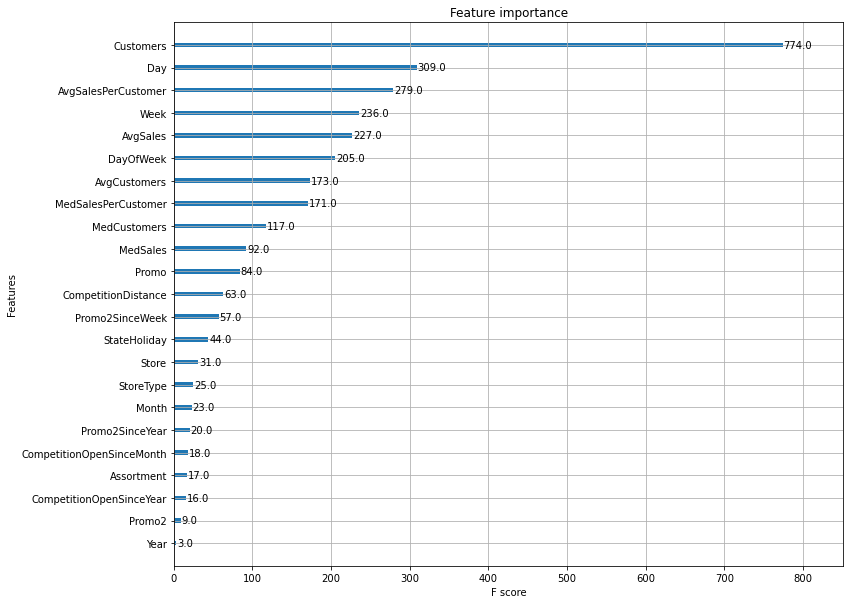

In [24]:
print("Note that this is not in percentage, thus not to scale of graphs above")
xgb.plot_importance(xgboost_tree)

In [25]:
def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, np.expm1(y_hat)))

y_hat = xgboost_tree.predict(X_test[X])
score(xgboost_tree, X_train[X], np.log1p(y_train), y_test, y_hat)

[11:50:41] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:50:50] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:51:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [26]:
test = pd.read_csv("./assets/test_v2.csv", parse_dates=[2], dtype=types)
features = build_features(test, store)

y_hat = np.expm1(xgboost_tree.predict(features[X]))

df = pd.DataFrame({"Id": range(1, len(test) + 1), 'Sales': y_hat})
df.loc[test['Open'] == 0, 'Sales'] = 1
df.to_csv('sales.csv', index=False)

C:\Users\hp\AppData\Local\Temp/ipykernel_9784/760113941.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = merged.Date.dt.week
C:\Users\hp\AppData\Local\Temp/ipykernel_9784/760113941.py:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])


In [27]:
features

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,MedSales,MedCustomers,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-07-31,555,1,1,0,1,5262.0,616.5,...,0,0,0,0,2015,7,31,31,82,0
1,2,5,2015-07-31,625,1,1,0,1,5661.5,620.0,...,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,31,31,92,78
2,3,5,2015-07-31,821,1,1,0,1,7474.5,759.5,...,1,14,2011,"Jan,Apr,Jul,Oct",2015,7,31,31,103,65
3,4,5,2015-07-31,1498,1,1,0,1,10341.5,1377.0,...,0,0,0,0,2015,7,31,31,70,0
4,5,5,2015-07-31,559,1,1,0,1,5201.0,586.0,...,0,0,0,0,2015,7,31,31,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33445,1111,4,2015-07-02,329,1,1,0,1,5351.0,453.0,...,1,31,2013,"Jan,Apr,Jul,Oct",2015,7,2,27,13,20
33446,1112,4,2015-07-02,577,1,1,0,1,9450.0,780.0,...,0,0,0,0,2015,7,2,27,111,0
33447,1113,4,2015-07-02,793,1,1,0,0,7233.0,740.0,...,0,0,0,0,2015,7,2,27,0,0
33448,1114,4,2015-07-02,3784,1,1,0,0,20821.0,3080.0,...,0,0,0,0,2015,7,2,27,0,0


Text(0, 0.5, 'sales')

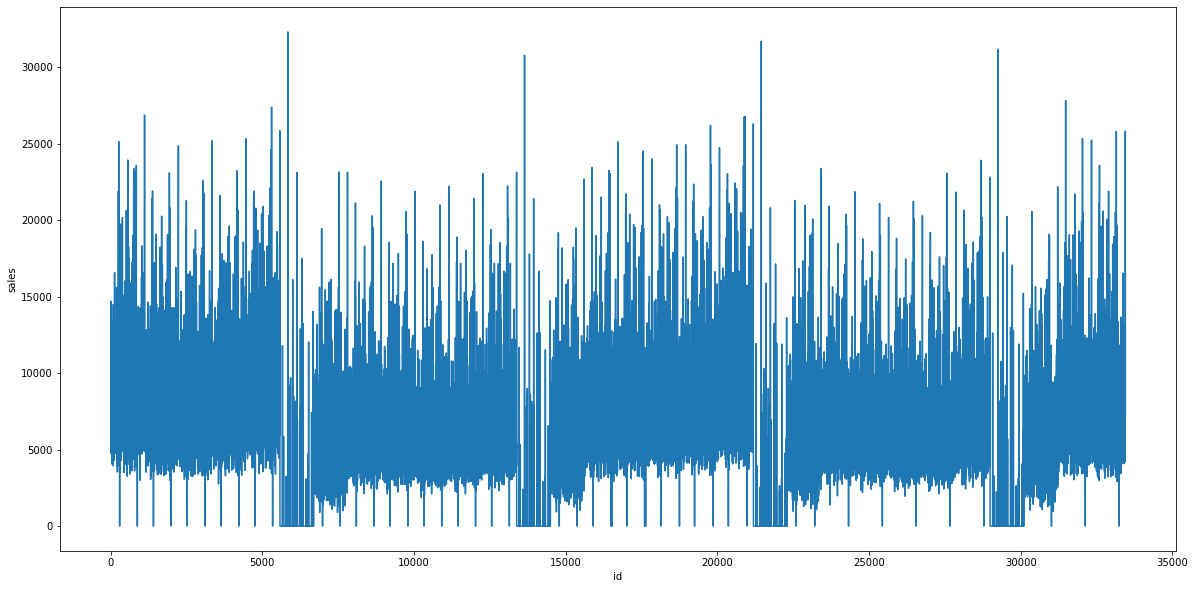

In [36]:
plt.rcParams["figure.figsize"] = (20.0,10.0)
data = np.genfromtxt("sales.csv", delimiter=",", names=["x", "y"])

plt.plot(data['x'], data['y'])
plt.xlabel("id")
plt.ylabel("sales")
